In [1]:
import os
import torch
import datetime
import numpy as np
from model import *
from tqdm import tqdm
from PIL import Image
from skimage import io
from scipy.io import loadmat, savemat
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

# MULTI CLASS CELLS

class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)
    
    """
    returns: tuple of
    - image
    - mask of size n x n with unique values/classes ranging from 0 to 4 
        0: background
        1: others (1)
        2: inflammatory(2)
        3: healthy epithelial(3) , dysplastic/malignant epithelial(4)
        4: fibroblast(5) , muscle(6) , endothelial(7)
    """
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        x = loadmat(mask_name)['type_map']
        x[(x==3)|(x==4)]=3
        x[(x==5)|(x==6)|(x==7)]=4
        x=np.pad(x.astype(int),6)
        if self.transform:
            image = self.transform(image)
        return image, to_categorical(x,5).transpose(2, 0, 1) #(num_classes=5, n, n)

In [3]:
transform = transforms.Compose([
    transforms.Pad(6),
    transforms.ToTensor()    
])

# DataLoader
train_ds = CellDataset(root_dir="./Train", transform = transform)
train_dataloader = DataLoader(train_ds, batch_size=1, shuffle=False)

test_ds = CellDataset(root_dir="./Test", transform = transform)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [4]:
print(list(np.unique(train_ds[0][1])))

[0, 1]


In [5]:
print(train_ds[0][1].shape)

(5, 1012, 1012)


In [6]:
print(list(np.unique(train_ds[0][1])))

[0, 1]


In [7]:
"""
0: black: background
1: red: others (1)
2: pink: inflammatory(2)
3: dark blue: healthy epithelial(3) , dysplastic/malignant epithelial(4)
4: light blue: fibroblast(5) , muscle(6) , endothelial(7)
"""
# params: 5 x n x n numpy or n x n x 5
def printColoredMask(npMask,numchannel=5): 
    if npMask.shape[-1]!=5:
        npMask=npMask.transpose(1, 2, 0)
    finalnpMask=np.where(npMask[:,:,1]==1,255,0) # one color
    finalnpMask=finalnpMask[:,:,None]
    temp=np.where((npMask[:,:,2]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    temp=np.where((npMask[:,:,3]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
#     print(finalnpMask.shape) #(n, n, 3)

#     finalnpMask=np.where(npMask==1,255,0) # one color
#     finalnpMask=finalnpMask[:,:,None]
#     temp=np.where((npMask==2)|(npMask==4),255,0) # one color
#     finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
#     temp=np.where((npMask==3)|(npMask==4),255,0) # one color
#     finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
#     print(finalnpMask.shape) #(n, n, 3)
    plt.imshow(finalnpMask)
    plt.show()

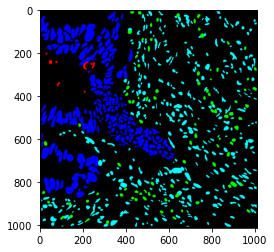

In [8]:
colormask = printColoredMask(train_ds[0][1])